In [45]:
import os
import re
import pandas as pd

# Arbeitsverzeichnis (NIST-Testdaten)
root_dir = r'C:\Workspace\jupyter\data\nist'

# Leere Liste für die Daten
data = []

# Gehe durch alle Unterverzeichnisse in NIST
for test_dir in os.listdir(root_dir):
    test_path = os.path.join(root_dir, test_dir)
    
    # Überprüfe, ob es sich um ein Verzeichnis handelt
    if os.path.isdir(test_path):
        # Modellnamen aus dem Verzeichnis extrahieren (z.B. "Pi1b" aus "testresult_Pi1b_2024.10.31_04.58_-v")
        match = re.search(r'Pi[^_]+', test_dir)
        model_name = match.group(0) if match else "Unknown"

        # Gehe durch alle Algorithmus-Verzeichnisse
        for subdir, dirs, files in os.walk(test_path):
            if 'PQCkemKAT.time' in files:
                file_path = os.path.join(subdir, 'PQCkemKAT.time')
                algorithm_name = os.path.basename(subdir)  # Algorithmusname aus Verzeichnisname extrahieren

                # Öffne die Datei mit UTF-8-Encoding
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.readlines()

                # Variablen für die extrahierten Daten
                count = None
                prepare = crypto_kem_keypair = crypto_kem_enc = crypto_kem_dec = None

                # Gehe durch jede Zeile und extrahiere die Werte
                for line in content:
                    if line.startswith("count ="):
                        if count is not None:
                            data.append([model_name, algorithm_name, count, prepare, crypto_kem_keypair, crypto_kem_enc, crypto_kem_dec])
                        count = int(line.split('=')[1].strip())

                    if 'prepare (μs)' in line:
                        prepare = int(line.split('=')[1].strip())
                    elif 'crypto_kem_keypair (μs)' in line:
                        crypto_kem_keypair = int(line.split('=')[1].strip())
                    elif 'crypto_kem_enc (μs)' in line:
                        crypto_kem_enc = int(line.split('=')[1].strip())
                    elif 'crypto_kem_dec (μs)' in line:
                        crypto_kem_dec = int(line.split('=')[1].strip())

                # Letzten Satz an Daten hinzufügen, falls vorhanden
                if count is not None:
                    data.append([model_name, algorithm_name, count, prepare, crypto_kem_keypair, crypto_kem_enc, crypto_kem_dec])

# Erstelle einen Pandas DataFrame mit der neuen "Model"-Spalte
df = pd.DataFrame(data, columns=['Model', 'Algorithmus', 'count', 'prepare (μs)', 'crypto_kem_keypair (μs)', 'crypto_kem_enc (μs)', 'crypto_kem_dec (μs)'])


In [142]:
# Ausgabe des DataFrames
print(df)


         Model  Algorithmus  count  prepare (μs)  crypto_kem_keypair (μs)  \
0     Pi1bPlus  BIG_QUAKE_1      0           605                  6285310   
1     Pi1bPlus  BIG_QUAKE_1      1           357                  6203085   
2     Pi1bPlus  BIG_QUAKE_1      2           364                  6195245   
3     Pi1bPlus  BIG_QUAKE_1      3           369                  6331622   
4     Pi1bPlus  BIG_QUAKE_1      4           365                  6298011   
...        ...          ...    ...           ...                      ...   
5068    PiZero        SABER      5           187                     2542   
5069    PiZero        SABER      6           184                     2487   
5070    PiZero        SABER      7           188                     2475   
5071    PiZero        SABER      8           185                     2475   
5072    PiZero        SABER      9           193                     2550   

      crypto_kem_enc (μs)  crypto_kem_dec (μs)  
0                   20168 

In [18]:
# Speichere den DataFrame als CSV-Datei
df.to_csv(r'PQCkemKAT.time.df.csv', index=False)


In [41]:
print("Verfügbare Algorithmen:", df['Algorithmus'].unique())

Verfügbare Algorithmen: ['BIG_QUAKE_1' 'BIG_QUAKE_3' 'BIG_QUAKE_5' 'EMBLEM-EMBLEM'
 'EMBLEM-R_EMBLEM' 'hqc-128' 'hqc-192' 'hqc-256' 'KCL-AKCN-MLWE'
 'KCL-AKCN-SEC' 'KCL-OKCN-MLWE' 'KCL-OKCN-SEC' 'kyber1024' 'kyber1024-90s'
 'kyber512' 'kyber512-90s' 'kyber768' 'kyber768-90s' 'Lima-EncapCCA_1018'
 'Lima-EncapCCA_1024' 'Lima-EncapCCA_1306' 'Lima-EncapCCA_1822'
 'Lima-EncapCCA_2048' 'Lima-EncapCCA_2062' 'Lima-EncapCPA_1018'
 'Lima-EncapCPA_1024' 'Lima-EncapCPA_1306' 'Lima-EncapCPA_1822'
 'Lima-EncapCPA_2048' 'Lima-EncapCPA_2062' 'mceliece348864'
 'mceliece348864f' 'mceliece460896' 'mceliece460896f' 'mceliece6688128'
 'mceliece6688128f' 'mceliece6960119' 'mceliece6960119f' 'mceliece8192128'
 'mceliece8192128f' 'newhope1024cca' 'newhope1024cpa' 'newhope512cca'
 'newhope512cpa' 'NTRU-Prime-ntrulpr1013' 'NTRU-Prime-ntrulpr1277'
 'NTRU-Prime-ntrulpr653' 'NTRU-Prime-ntrulpr761' 'NTRU-Prime-ntrulpr857'
 'NTRU-Prime-ntrulpr953' 'NTRU-Prime-sntrup1013' 'NTRU-Prime-sntrup1277'
 'NTRU-Prime-sntrup65

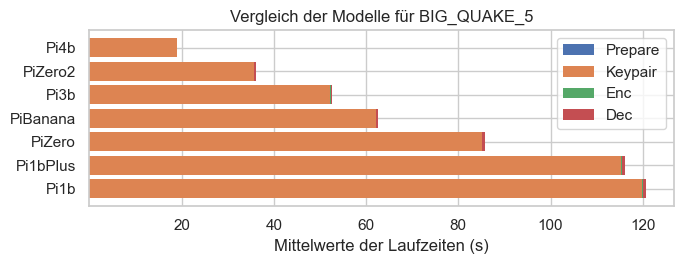

In [115]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Gewünschter Algorithmus für die Analyse
# BIG_QUAKE_5 hqc-256
selected_algorithm = "BIG_QUAKE_5"  # Standardmäßig Kyber-768 auswählen

# Ausgabe der Gesamtzeit für alle Modelle
#print("Gesamtzeit für alle Modelle:")
#print(df_mean[['Model', f'Total Time ({time_unit})']])

# Prüfe, ob df existiert, bevor es überschrieben wird
if 'df' not in globals():
    raise ValueError("Fehler: DataFrame 'df' nicht gefunden. Stelle sicher, dass Stage 1 zuerst ausgeführt wurde.")

# Setze den Stil für die Plots
sns.set(style="whitegrid")

# Filtere den gewünschten Algorithmus
df_selected = df[df['Algorithmus'] == selected_algorithm]

# Debugging: Mittelwerte für Pi4b ausgeben
if 'Pi4b' in df_selected['Model'].values:
    pi4b_values_original = df_selected[df_selected['Model'] == 'Pi4b'][['prepare (μs)', 'crypto_kem_keypair (μs)', 'crypto_kem_enc (μs)', 'crypto_kem_dec (μs)']].mean()
    #print("Mittelwerte für Pi4b (skaliert):")
    #print(pi4b_values_original / scale_factor)

# Prüfe, ob Daten vorhanden sind
if df_selected.empty:
    raise ValueError(f"Keine Daten für den Algorithmus {selected_algorithm} gefunden. Überprüfe die Stage 1-Ausgabe.")

# Nur numerische Spalten für die Berechnung des Mittelwerts verwenden
df_numeric = df_selected.select_dtypes(include=[np.number])
df_numeric['Model'] = df_selected['Model']  # Model wieder hinzufügen

# Gruppiere die Daten nach Model und berechne den Mittelwert
df_mean = df_numeric.groupby('Model').mean(numeric_only=True).reset_index()

# Berechne die Summe der vier Werte für eine konsistente Skalierung und Sortierung
df_mean['Total Time (μs)'] = df_mean[['prepare (μs)', 'crypto_kem_keypair (μs)', 'crypto_kem_enc (μs)', 'crypto_kem_dec (μs)']].sum(axis=1)

# Ausgabe der min/max Gesamtzeit für Debugging
#print(f"Max Time: {max_time} μs ({max_time / scale_factor} {time_unit})")
#print(f"Min Time: {min_time} μs ({min_time / scale_factor} {time_unit})")

# Bestimme die Skalierung basierend auf der Gesamtzeit (Min- und Max-Werte berücksichtigen)

max_time = df_mean['Total Time (μs)'].max()
min_time = df_mean['Total Time (μs)'].min()

if max_time >= 3600000000 and min_time >= 3600000000:
    scale_factor, time_unit = 3600000000, "h"
elif max_time >= 60000000 and min_time >= 60000000:
    scale_factor, time_unit = 60000000, "min"
elif max_time >= 1000000 and min_time >= 1000000:
    scale_factor, time_unit = 1000000, "s"
elif max_time >= 1000 and min_time >= 1000:
    scale_factor, time_unit = 1000, "ms"
else:
    scale_factor, time_unit = 1, "μs"


# Skaliere alle relevanten Werte und passe die Spaltennamen an
scaled_columns = ['prepare (μs)', 'crypto_kem_keypair (μs)', 'crypto_kem_enc (μs)', 'crypto_kem_dec (μs)', 'Total Time (μs)']
df_mean[scaled_columns] /= scale_factor

# Spaltennamen an die neue Einheit anpassen
df_mean.rename(columns={
    'prepare (μs)': f'prepare ({time_unit})',
    'crypto_kem_keypair (μs)': f'crypto_kem_keypair ({time_unit})',
    'crypto_kem_enc (μs)': f'crypto_kem_enc ({time_unit})',
    'crypto_kem_dec (μs)': f'crypto_kem_dec ({time_unit})',
    'Total Time (μs)': f'Total Time ({time_unit})'
}, inplace=True)


# Sortiere nach der Gesamtzeit absteigend
df_mean = df_mean.sort_values(by=f'Total Time ({time_unit})', ascending=False)

# Erstelle eine Figure für das gestapelte Balkendiagramm
fig, ax = plt.subplots(figsize=(7, 2.8))

# Positionen für die Balken
y = np.arange(len(df_mean['Model']))

# Erstelle gestapelte Balken ohne weiße Trennlinien
ax.barh(y, df_mean[f'prepare ({time_unit})'], label='Prepare', edgecolor='none')
ax.barh(y, df_mean[f'crypto_kem_keypair ({time_unit})'], left=df_mean[f'prepare ({time_unit})'], label='Keypair', edgecolor='none')
ax.barh(y, df_mean[f'crypto_kem_enc ({time_unit})'], left=df_mean[f'prepare ({time_unit})'] + df_mean[f'crypto_kem_keypair ({time_unit})'], label='Enc', edgecolor='none')
ax.barh(y, df_mean[f'crypto_kem_dec ({time_unit})'], left=df_mean[f'prepare ({time_unit})'] + df_mean[f'crypto_kem_keypair ({time_unit})'] + df_mean[f'crypto_kem_enc ({time_unit})'], label='Dec', edgecolor='none')

# Achsenbeschriftungen
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
ax.set_xlabel(f"Mittelwerte der Laufzeiten ({time_unit})")


ax.set_title(f"Vergleich der Modelle für {selected_algorithm}")
ax.set_yticks(y)
ax.set_yticklabels(df_mean['Model'])
ax.legend()

# Diagramm anzeigen
plt.tight_layout()
plt.show()


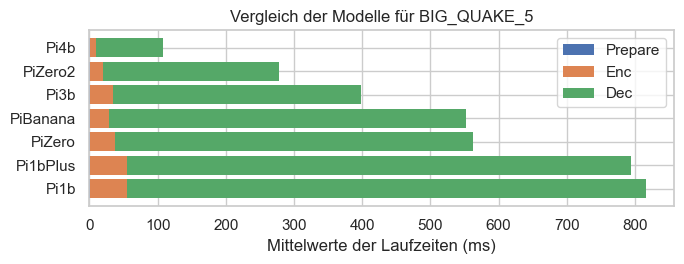

In [117]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Gewünschter Algorithmus für die Analyse
# BIG_QUAKE_5 hqc-256
selected_algorithm = "BIG_QUAKE_5"  # Standardmäßig Kyber-768 auswählen

# Ausgabe der Gesamtzeit für alle Modelle
#print("Gesamtzeit für alle Modelle:")
#print(df_mean[['Model', f'Total Time ({time_unit})']])

# Prüfe, ob df existiert, bevor es überschrieben wird
if 'df' not in globals():
    raise ValueError("Fehler: DataFrame 'df' nicht gefunden. Stelle sicher, dass Stage 1 zuerst ausgeführt wurde.")

# Setze den Stil für die Plots
sns.set(style="whitegrid")

# Filtere den gewünschten Algorithmus
df_selected = df[df['Algorithmus'] == selected_algorithm]

# Debugging: Mittelwerte für Pi4b ausgeben
if 'Pi4b' in df_selected['Model'].values:
    pi4b_values_original = df_selected[df_selected['Model'] == 'Pi4b'][['prepare (μs)', 'crypto_kem_keypair (μs)', 'crypto_kem_enc (μs)', 'crypto_kem_dec (μs)']].mean()
    #print("Mittelwerte für Pi4b (skaliert):")
    #print(pi4b_values_original / scale_factor)

# Prüfe, ob Daten vorhanden sind
if df_selected.empty:
    raise ValueError(f"Keine Daten für den Algorithmus {selected_algorithm} gefunden. Überprüfe die Stage 1-Ausgabe.")

# Nur numerische Spalten für die Berechnung des Mittelwerts verwenden
df_numeric = df_selected.select_dtypes(include=[np.number])
df_numeric['Model'] = df_selected['Model']  # Model wieder hinzufügen

# Gruppiere die Daten nach Model und berechne den Mittelwert
df_mean = df_numeric.groupby('Model').mean(numeric_only=True).reset_index()

# Berechne die Summe der vier Werte für eine konsistente Skalierung und Sortierung
df_mean['Total Time (μs)'] = df_mean[['prepare (μs)', 'crypto_kem_enc (μs)', 'crypto_kem_dec (μs)']].sum(axis=1)

# Ausgabe der min/max Gesamtzeit für Debugging
#print(f"Max Time: {max_time} μs ({max_time / scale_factor} {time_unit})")
#print(f"Min Time: {min_time} μs ({min_time / scale_factor} {time_unit})")

# Bestimme die Skalierung basierend auf der Gesamtzeit (Min- und Max-Werte berücksichtigen)

max_time = df_mean['Total Time (μs)'].max()
min_time = df_mean['Total Time (μs)'].min()

if max_time >= 3600000000 and min_time >= 3600000000:
    scale_factor, time_unit = 3600000000, "h"
elif max_time >= 60000000 and min_time >= 60000000:
    scale_factor, time_unit = 60000000, "min"
elif max_time >= 1000000 and min_time >= 1000000:
    scale_factor, time_unit = 1000000, "s"
elif max_time >= 1000 and min_time >= 1000:
    scale_factor, time_unit = 1000, "ms"
else:
    scale_factor, time_unit = 1, "μs"


# Skaliere alle relevanten Werte und passe die Spaltennamen an
scaled_columns = ['prepare (μs)', 'crypto_kem_enc (μs)', 'crypto_kem_dec (μs)', 'Total Time (μs)']
df_mean[scaled_columns] /= scale_factor

# Spaltennamen an die neue Einheit anpassen
df_mean.rename(columns={
    'prepare (μs)': f'prepare ({time_unit})',
    'crypto_kem_enc (μs)': f'crypto_kem_enc ({time_unit})',
    'crypto_kem_dec (μs)': f'crypto_kem_dec ({time_unit})',
    'Total Time (μs)': f'Total Time ({time_unit})'
}, inplace=True)


# Sortiere nach der Gesamtzeit absteigend
df_mean = df_mean.sort_values(by=f'Total Time ({time_unit})', ascending=False)

# Erstelle eine Figure für das gestapelte Balkendiagramm
fig, ax = plt.subplots(figsize=(7, 2.8))

# Positionen für die Balken
y = np.arange(len(df_mean['Model']))

# Erstelle gestapelte Balken ohne weiße Trennlinien
ax.barh(y, df_mean[f'prepare ({time_unit})'], label='Prepare', edgecolor='none')
ax.barh(y, df_mean[f'crypto_kem_enc ({time_unit})'], left=df_mean[f'prepare ({time_unit})'] , label='Enc', edgecolor='none')
ax.barh(y, df_mean[f'crypto_kem_dec ({time_unit})'], left=df_mean[f'prepare ({time_unit})'] +  df_mean[f'crypto_kem_enc ({time_unit})'], label='Dec', edgecolor='none')

# Achsenbeschriftungen
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
ax.set_xlabel(f"Mittelwerte der Laufzeiten ({time_unit})")


ax.set_title(f"Vergleich der Modelle für {selected_algorithm}")
ax.set_yticks(y)
ax.set_yticklabels(df_mean['Model'])
ax.legend()

# Diagramm anzeigen
plt.tight_layout()
plt.show()


In [46]:
import os
import pandas as pd
import numpy as np

# Prüfe, ob df existiert, bevor es überschrieben wird
if 'df' not in globals():
    raise ValueError("Fehler: DataFrame 'df' nicht gefunden. Stelle sicher, dass Stage 1 zuerst ausgeführt wurde.")

# Nur numerische Spalten für die Zeit-Berechnungen verwenden
df_numeric = df.select_dtypes(include=[np.number]).copy()

# Hänge Model und Algorithmus an
df_numeric['Model'] = df['Model']
df_numeric['Algorithmus'] = df['Algorithmus']

# Definiere die Zeitspalten, die aggregiert werden sollen
time_columns = ['crypto_kem_keypair (μs)',
                'crypto_kem_enc (μs)',
                'crypto_kem_dec (μs)']

# Gruppierung nach Model und Algorithmus
grouped = df_numeric.groupby(['Model', 'Algorithmus'])

# ──────────────────────────────────────────────────────────────────────────────
# 1) Aggregation der Zeitspalten: Mittelwert (mean) oder Median
# ──────────────────────────────────────────────────────────────────────────────

# a) Durchschnitt
df_agg_time = grouped[time_columns].mean(numeric_only=True)

# b) Median (falls du lieber den Median nutzen möchtest)
# df_agg_time = grouped[time_columns].median(numeric_only=True)

# ──────────────────────────────────────────────────────────────────────────────
# 2) Anzahl der Datensätze in jeder Gruppe -> "Runden"
# ──────────────────────────────────────────────────────────────────────────────
df_count = grouped.size()  # Anzahl Zeilen pro (Model, Algorithmus)

# Kombiniere beides in einen DataFrame
df_combined = df_agg_time.join(df_count.rename("Runden"))

# Index zurück in Spalten
df_combined.reset_index(inplace=True)

# ──────────────────────────────────────────────────────────────────────────────
# 3) Summe der Zeitspalten + Umrechnung in ms
# ──────────────────────────────────────────────────────────────────────────────
df_combined['Total Time (μs)'] = df_combined[time_columns].sum(axis=1)

scale_factor, time_unit = 1000, "ms"

# Relevante Spalten für die Zeit-Skalierung
scaled_columns = time_columns + ['Total Time (μs)']

# Umrechnung von μs auf ms
df_combined[scaled_columns] = df_combined[scaled_columns].div(scale_factor)

# Spalten umbenennen
df_combined.rename(columns={
    'crypto_kem_keypair (μs)': f'kem_keypair ({time_unit})',
    'crypto_kem_enc (μs)': f'kem_enc ({time_unit})',
    'crypto_kem_dec (μs)': f'kem_dec ({time_unit})',
    'Total Time (μs)': f'Total Time ({time_unit})'
}, inplace=True)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Formatierung der Zeitspalten
#    Werte < 1 => 3 Nachkommastellen, sonst 2
# ──────────────────────────────────────────────────────────────────────────────
def custom_format(x):
    if pd.isna(x):
        return x
    return f"{x:.3f}".replace('.', ',') # if x < 1 else f"{x:.2f}"

time_cols = [
    f'kem_keypair ({time_unit})',
    f'kem_enc ({time_unit})',
    f'kem_dec ({time_unit})',
    f'Total Time ({time_unit})'
]
for col in time_cols:
    if col in df_combined.columns:
        df_combined[col] = df_combined[col].apply(custom_format)

# Runden als ganze Zahl
df_combined['Runden'] = df_combined['Runden'].astype(int)

# ──────────────────────────────────────────────────────────────────────────────
# 5) Sortierung nach Algorithmus
# ──────────────────────────────────────────────────────────────────────────────
df_combined.sort_values(by=["Algorithmus", "Model"], inplace=True)
df_combined.reset_index(drop=True, inplace=True)

# ──────────────────────────────────────────────────────────────────────────────
# 6) Spaltenreihenfolge anpassen → "Runden" direkt nach "Algorithmus"
# ──────────────────────────────────────────────────────────────────────────────
# Aktuelle Spalten ermitteln
all_cols = df_combined.columns.tolist()

# Gewünschte Reihenfolge: Model, Algorithmus, Runden, gefolgt von allen anderen
desired_cols = ['Model', 'Algorithmus', 'Runden',
                f'kem_keypair ({time_unit})', 
                f'kem_enc ({time_unit})', 
                f'kem_dec ({time_unit})', 
                f'Total Time ({time_unit})']

# Für den Fall, dass andere Spalten existieren, hängen wir diese hinten an
remaining_cols = [c for c in all_cols if c not in desired_cols]
new_cols = desired_cols + remaining_cols

df_combined = df_combined[new_cols]

# Speichere als CSV
df_combined.to_csv(r'PQCkemKAT.kem.time.mittelwert.csv', index=False)

# Zur Anzeige im Notebook
#from IPython.display import display
print("Aggregierte Zeiten + Anzahl Datensätze (Runden) nach (Model, Algorithmus):")
#display(df_combined)

#df_combined[df_combined.select_dtypes(include=['float64', 'float32']).columns] = (
#    df_combined.select_dtypes(include=['float64', 'float32']).map(lambda x: f"{x:.3f}".replace('.', ','))
#)
#display(df_combined)
df_combined


Aggregierte Zeiten + Anzahl Datensätze (Runden) nach (Model, Algorithmus):


,Model,Algorithmus,Runden,kem_keypair (ms),kem_enc (ms),kem_dec (ms),Total Time (ms)
0,Pi1b,BIG_QUAKE_1,5,"6358,335","19,880","39,674","6417,890"
1,Pi1bPlus,BIG_QUAKE_1,5,"6262,655","19,873","39,140","6321,667"
2,Pi3b,BIG_QUAKE_1,5,"3202,176","11,460","18,666","3232,302"
3,Pi4b,BIG_QUAKE_1,5,"667,457","2,920","4,005","674,382"
4,PiBanana,BIG_QUAKE_1,5,"2530,669","10,661","15,523","2556,852"
...,...,...,...,...,...,...,...
573,Pi3b,newhope512cpa,10,"0,449","0,658","0,199","1,306"
574,Pi4b,newhope512cpa,10,"0,079","0,113","0,029","0,221"
575,PiBanana,newhope512cpa,10,"0,624","0,820","0,132","1,575"
576,PiZero,newhope512cpa,10,"0,894","1,315","0,251","2,460"
